<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_naive_bayes(mnb).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [81]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')


test = pd.read_csv('drive/Shareddrives/Milestone 2/Testing_set.csv', sep='\t',
                     index_col='ix')
test['lemmatized_text'] = test['lemmatized_text'].fillna('')

In [82]:
 #Class proportions
train.label.value_counts()/ len(train)

1    0.5
0    0.5
Name: label, dtype: float64

In [83]:
print(f"Training set dimensions: {train.shape}")
print(f"label counts from training split (order is positive, negative): {train.label.value_counts().values}")

print(f"Testing set dimensions: {test.shape}")
print(f"label counts from training split (order is positive, negative): {test.label.value_counts().values}")


Training set dimensions: (375092, 11)
label counts from training split (order is positive, negative): [187546 187546]
Testing set dimensions: (41676, 11)
label counts from training split (order is positive, negative): [20838 20838]


In [ ]:
train.head()

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1
2,"Before Persephone was released to Hermes , who...",before persephone be release to hermes who hav...,6.594628,5.231351,2.78,11.17,2.537222,1.43,4.86,42.0,1
3,Cogeneration plants are commonly found in dist...,cogeneration plant be commonly find in distric...,7.015012,6.742000,3.56,11.53,3.429643,1.52,4.93,32.0,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",geneva lrb rrb be the secondmostpopulous city ...,9.847729,5.455000,3.69,12.62,2.399333,1.43,4.79,28.0,1


In [84]:
metrics_df = {"model_name":[],
              "model_instance":[],
              "train_accuracy": [],
              "train_precision": [],
              "train_recall": [],
              "train_f1": [],
              "train_aucprc":[],
              "train_aucroc": [],
              "test_accuracy":[],
              "test_precision":[],
              "test_f1": [],
              "test_recall":[],
              "test_aucprc":[],
              "test_aucroc": []
              }

In [85]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_auc_score, auc, accuracy_score,f1_score, confusion_matrix

In [86]:
def generate_model_name(model):
  for key,value in model.best_params_.items():
    model_name += f" {key}_{value}"
  return model_name

def compute_metrics(model,model_name,X_train_data,y_train_data, X_test_data, y_test_data):
    # extract the model's hyperparameters and make that part of the identifier for the model 

    metrics_df['model_name'].append(model_name)
    metrics_df['model_instance'].append(model)
   
    # run train data
    y_pred_train = model.predict(X_train_data)
    acc = accuracy_score(y_train_data, y_pred_train)
    recall = recall_score(y_train_data,y_pred_train)
    precision = precision_score(y_train_data, y_pred_train)
    f1 = f1_score(y_train_data,y_pred_train)
    y_proba_train = model.predict_proba(X_train_data)[:,1]
    prc,rec,thres = precision_recall_curve(y_train_data, y_proba_train)
    auc_prc = auc(rec,prc)
    roc = roc_auc_score(y_train_data, y_proba_train)
   
   
    metrics_df['train_accuracy'].append(acc)
    metrics_df['train_recall'].append(recall)
    metrics_df['train_precision'].append(precision)
    metrics_df['train_f1'].append(f1)
    metrics_df['train_aucprc'].append(auc_prc)
    metrics_df['train_aucroc'].append(roc)


    #run test data
    y_pred = model.predict(X_test_data)
    acc = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data,y_pred)
    precision = precision_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data,y_pred)
    y_proba = model.predict_proba(X_test_data)[:,1]
    prc,rec,thres = precision_recall_curve(y_test_data, y_proba)
    auc_prc = auc(rec,prc)
    roc = roc_auc_score(y_test_data, y_proba)

    metrics_df['test_accuracy'].append(acc)
    metrics_df['test_recall'].append(recall)
    metrics_df['test_precision'].append(precision)
    metrics_df['test_f1'].append(f1)
    metrics_df['test_aucprc'].append(auc_prc)
    metrics_df['test_aucroc'].append(roc)

    cm = confusion_matrix(y_test_data, y_pred)
    return cm





In [87]:
#create a balanced sample from the training set

sample_df = train.groupby('label').apply(lambda x: x.sample(30000, random_state=99))
sample_df.label.value_counts()

X_train_samp = sample_df.iloc[:,:-1]
y_train_samp = sample_df['label']

### **Naive Bayes with Tfidf Vectorizer**

In [ ]:
# NaiveBayes Classifier with Tfidf Vectorizer
from sklearn.naive_bayes import MultinomialNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [ ]:
# due to the amount of time it took to run the tfidf vectorizer, I manually 
# tested min_df settings and determined the optimal range to be in the 20s



pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())
                    ])

parameters = {
    'tfidf__min_df': [0,25,30],
    'tfidf__stop_words': ['english'],
    'tfidf__ngram_range': [(1, 3)],
    'clf__alpha': [1,5,10,50,100]
}

In [ ]:
grid_bnb_f1 = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            scoring='f1', 
                            cv=StratifiedKFold(n_splits=10),
                            return_train_score=True, 
                            n_jobs=-1).fit(X_train_samp['lemmatized_text'],y_train_samp)
grid_bnb_f1.best_params_

{'clf__alpha': 10,
 'tfidf__min_df': 0,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': 'english'}

In [ ]:
pd.DataFrame(grid_bnb_f1.cv_results_)['params'].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
mean_fit_time,7.528033,4.211036,4.22692,7.279756,4.158957,4.172224,7.183224,4.211907,4.176663,7.15948,4.104081,4.161108,7.204594,4.098873,4.007649
std_fit_time,0.506192,0.057218,0.050837,0.107504,0.076526,0.067155,0.111254,0.081724,0.143769,0.132641,0.122885,0.022143,0.151784,0.134152,0.493202
mean_score_time,0.354358,0.288866,0.283225,0.35382,0.300401,0.303168,0.339582,0.300716,0.299001,0.354933,0.282521,0.273392,0.360336,0.295598,0.285147
std_score_time,0.012704,0.023879,0.02262,0.021821,0.018224,0.012796,0.017496,0.006647,0.013467,0.009837,0.018968,0.02456,0.015041,0.011586,0.042833
param_clf__alpha,1,1,1,5,5,5,10,10,10,50,50,50,100,100,100
param_tfidf__min_df,0,25,30,0,25,30,0,25,30,0,25,30,0,25,30
param_tfidf__ngram_range,"(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)"
param_tfidf__stop_words,english,english,english,english,english,english,english,english,english,english,english,english,english,english,english
params,"{'clf__alpha': 1, 'tfidf__min_df': 0, 'tfidf__...","{'clf__alpha': 1, 'tfidf__min_df': 25, 'tfidf_...","{'clf__alpha': 1, 'tfidf__min_df': 30, 'tfidf_...","{'clf__alpha': 5, 'tfidf__min_df': 0, 'tfidf__...","{'clf__alpha': 5, 'tfidf__min_df': 25, 'tfidf_...","{'clf__alpha': 5, 'tfidf__min_df': 30, 'tfidf_...","{'clf__alpha': 10, 'tfidf__min_df': 0, 'tfidf_...","{'clf__alpha': 10, 'tfidf__min_df': 25, 'tfidf...","{'clf__alpha': 10, 'tfidf__min_df': 30, 'tfidf...","{'clf__alpha': 50, 'tfidf__min_df': 0, 'tfidf_...","{'clf__alpha': 50, 'tfidf__min_df': 25, 'tfidf...","{'clf__alpha': 50, 'tfidf__min_df': 30, 'tfidf...","{'clf__alpha': 100, 'tfidf__min_df': 0, 'tfidf...","{'clf__alpha': 100, 'tfidf__min_df': 25, 'tfid...","{'clf__alpha': 100, 'tfidf__min_df': 30, 'tfid..."
split0_test_score,0.659764,0.63738,0.630789,0.678022,0.633414,0.628906,0.678489,0.635523,0.631816,0.669498,0.65175,0.643555,0.667308,0.65818,0.651025


In [ ]:
# Based on the data above it looks like the best models are overfitting.  the 5th bridges the
# gap between mean test and training (for f1) with minimal sacrifice to f1 score.

In [ ]:
grid_bnb_f1.best_params_

{'clf__alpha': 10,
 'tfidf__min_df': 0,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': 'english'}

In [ ]:
tfidf_prefix = 'tfidf__'
tfidf_best_params = {k[len(tfidf_prefix):]:v 
                     for (k, v) in grid_bnb_f1.best_params_.items() 
                     if tfidf_prefix in k}

In [ ]:
tfidf_vec = grid_bnb_f1.best_estimator_.named_steps['tfidf']
best_tfidf_model = grid_bnb_f1.best_estimator_.named_steps['clf']
neg_tfidf_class = best_tfidf_model.feature_log_prob_[0, :].argsort()[::-1]
pos_tfidf_class = best_tfidf_model.feature_log_prob_[1, :].argsort()[::-1]

In [ ]:
print("Top words in negative class:", np.take(tfidf_vec.get_feature_names_out(), neg_tfidf_class[:20]))
print("words in positive class:", np.take(tfidf_vec.get_feature_names_out(), pos_tfidf_class[:20]))

Top words in negative class: ['rrb' 'lrb' 'reference' 'france' 'region' 'department' 'state' 'city'
 'use' 'commune' 'north' 'bear' 'make' 'united' 'websites' 'people' 'play'
 'united state' 'lrb bear' 'football']
words in positive class: ['rrb' 'lrb' 'france' 'commune' 'department' 'state' 'city' 'use' 'bear'
 'region' 'know' 'united' 'year' 'county' 'new' 'united state' 'play'
 'world' 'include' 'lrb bear']


In [ ]:
# Negative Class Feature Importance by Log Probabilities
list(zip(np.take(tfidf_vec.get_feature_names_out(), neg_tfidf_class[:20]),
         [best_tfidf_model.feature_log_prob_[0,idx] for idx in neg_tfidf_class]))

[('rrb', -10.346394556587768),
 ('lrb', -10.352417254189472),
 ('reference', -10.774317390071342),
 ('france', -10.905883825197542),
 ('region', -10.955485472794727),
 ('department', -11.025090490184095),
 ('state', -11.03380473603832),
 ('city', -11.081954492765217),
 ('use', -11.111871008867483),
 ('commune', -11.218841571328781),
 ('north', -11.227140641286768),
 ('bear', -11.229249596718503),
 ('make', -11.245294416387917),
 ('united', -11.2752763221002),
 ('websites', -11.298091983026058),
 ('people', -11.402404930212125),
 ('play', -11.429928524485032),
 ('united state', -11.437710756963908),
 ('lrb bear', -11.438157294248432),
 ('football', -11.455888886192371)]

In [ ]:
# Positive Class Feature Importance by Log Probabilities
list(zip(np.take(tfidf_vec.get_feature_names_out(), pos_tfidf_class[:20]),
         [best_tfidf_model.feature_log_prob_[1,idx] for idx in pos_tfidf_class]))

[('rrb', -10.053384205135416),
 ('lrb', -10.102971201713672),
 ('france', -10.913678359149692),
 ('commune', -10.932926711223653),
 ('department', -10.96395892035978),
 ('state', -11.087223686135488),
 ('city', -11.215009375642913),
 ('use', -11.24636693244113),
 ('bear', -11.306019037560127),
 ('region', -11.338258435148173),
 ('know', -11.379260095852864),
 ('united', -11.382444352377298),
 ('year', -11.437198718581925),
 ('county', -11.466780079810732),
 ('new', -11.538321253890697),
 ('united state', -11.575595461295352),
 ('play', -11.608439106091378),
 ('world', -11.609407038581635),
 ('include', -11.611825319187584),
 ('lrb bear', -11.614627218379349)]

In [ ]:
grid_bnb_f1.best_estimator_.score(X_test['lemmatized_text'], y_test)

In [ ]:
# tf_vec = TfidfVectorizer(min_df = 30,
#                          stop_words='english',
#                          ngram_range=(1, 2))

In [ ]:
# X_train_vec = tf_vec.fit_transform(X_train['lemmatized_text'])
# X_test_vec = tf_vec.transform(X_test['lemmatized_text'])

In [ ]:
# bnb = MultinomialNB(alpha=.1).fit(X_train_vec,y_train)
# bnb.score(X_test_vec,y_test)
# manual_params = {'alpha': [0.001, 0.01, 0.1, 1,5,10,50, 100]}
# grid_bn_acc = GridSearchCV(MultinomialNB(), param_grid=param_grid)
# grid_bn_acc.fit(X_train_vec,y_train)
# grid_bn_acc.best_estimator_.score(tf_vec.transform(X_test['lemmatized_text']),y_test)

# Mads Features

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# X_train_mads_features = X_train.iloc[:,1:9]
# mads_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# X_train_mads_features_imp = mads_mean.fit_transform(X_train_mads_features)

In [ ]:
cols = ['d_chall_score','aoa_mean','aoa_min','aoa_max','conc_rating_mean','conc_rating_min', 'conc_rating_max','num_lemmas']
X_train_samp_mads_features = X_train_samp[:][cols]
# X_test_mads_features = X_test.iloc[:][cols]
# X_train_mads_features.describe()

In [ ]:
mads_pipeline = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                          ('scaler', MinMaxScaler()),
                          ('clf', MultinomialNB())
                         ])

parameters = {
    'clf__alpha': [1000,2000,5000,10000,2000]
}

In [ ]:
grid_bnb_mads_f1 = (GridSearchCV(mads_pipeline,
                                  param_grid=parameters,
                                  scoring='f1',
                                  n_jobs=-1,
                                  return_train_score=True, 
                                  cv=10).fit(X_train_samp_mads_features,y_train_samp))

In [ ]:
best_model = grid_bnb_mads_f1.best_estimator_.named_steps['clf']


neg_class = best_model.feature_log_prob_[0, :].argsort()[::-1]
pos_class = best_model.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(cols, neg_class[:20]))
print(np.take(cols, pos_class[:20]))





['conc_rating_max' 'aoa_max' 'd_chall_score' 'conc_rating_mean' 'aoa_mean'
 'num_lemmas' 'aoa_min' 'conc_rating_min']
['conc_rating_max' 'aoa_max' 'd_chall_score' 'conc_rating_mean' 'aoa_mean'
 'num_lemmas' 'aoa_min' 'conc_rating_min']


In [ ]:
pd.DataFrame(grid_bnb_mads_f1.cv_results_).T

,0,1,2,3,4
mean_fit_time,0.038595,0.03673,0.041268,0.038802,0.038695
std_fit_time,0.002676,0.000706,0.008389,0.001629,0.006376
mean_score_time,0.008569,0.008952,0.008238,0.008381,0.008408
std_score_time,0.000759,0.002258,0.000635,0.000645,0.001236
param_clf__alpha,1000,2000,5000,10000,2000
params,{'clf__alpha': 1000},{'clf__alpha': 2000},{'clf__alpha': 5000},{'clf__alpha': 10000},{'clf__alpha': 2000}
split0_test_score,0.640151,0.648649,0.663482,0.676282,0.648649
split1_test_score,0.652816,0.660867,0.672743,0.68123,0.660867
split2_test_score,0.644489,0.652858,0.667624,0.67247,0.652858
split3_test_score,0.635978,0.643563,0.660141,0.672735,0.643563


In [ ]:
# Negative Class Feature Importance by Log Probabilities
list(zip(np.take(cols, neg_class[:10]),
         [best_model.feature_log_prob_[0,idx] for idx in neg_class]))

[('conc_rating_max', -1.5705414789316272),
 ('aoa_max', -1.934174505308528),
 ('d_chall_score', -2.0239245682117915),
 ('conc_rating_mean', -2.0737817878789144),
 ('aoa_mean', -2.1764506662142313),
 ('num_lemmas', -2.306075638325815),
 ('aoa_min', -2.364948716985454),
 ('conc_rating_min', -2.493389528081421)]

In [ ]:
# Positive Class Feature Importance by Log Probabilities
list(zip(np.take(cols, pos_class[:10]),
         [best_model.feature_log_prob_[1,idx] for idx in pos_class]))

[('conc_rating_max', -1.5749592692537977),
 ('aoa_max', -1.8926210046116339),
 ('d_chall_score', -2.016299740038024),
 ('conc_rating_mean', -2.115332032030212),
 ('aoa_mean', -2.1888422046797444),
 ('num_lemmas', -2.201048737163255),
 ('aoa_min', -2.4192348351355335),
 ('conc_rating_min', -2.565976941173453)]

In [ ]:
grid_bnb_mads_f1.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('clf', MultinomialNB(alpha=500))])

In [ ]:
X_test_mads_features

In [ ]:
grid_bnb_mads_f1.best_estimator_.score(X_train_mads_features, y_train)

In [ ]:
grid_bnb_mads_f1.best_params_

In [ ]:
model_name = 'MADS BNB alpha 10'
compute_metrics(grid_bnb_mads_f1.best_estimator_,
                model_name,
                X_train_mads_features,
                y_train,
                X_test_mads_features,
                y_test)

In [ ]:
# tfidf + Mads features

# tfidf + Mads Features

In [88]:
import numpy as np
from sklearn.compose import ColumnTransformer

In [89]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer


vectorizer = Pipeline([
              # ('select', list_trf),
              ('tfidf', TfidfVectorizer())
              ])

mads_pipe = Pipeline([
              ('impute_mean',SimpleImputer(strategy='mean')),
              ('scaler',MinMaxScaler()),
              ('bin',KBinsDiscretizer(n_bins=4))
              ])

preprocessor = ColumnTransformer(transformers=[
    ('mads',mads_pipe,cols),
    ('text', vectorizer, 'lemmatized_text')
    ])


              
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('clf', MultinomialNB())  # classifier
                     ])

In [93]:
tfidf_prefix = 'preprocessor__text__tfidf__'

parameters = {
    tfidf_prefix + 'min_df': [10,20],
    tfidf_prefix + 'stop_words': [None],
    tfidf_prefix + 'ngram_range' : [(1, 3)],
    'clf__alpha': [.005,0.01]
}

grid_mnb_all_f1= (GridSearchCV(pipeline,
                                  param_grid=parameters,
                                  scoring='f1',
                                  n_jobs=-1,
                                  return_train_score=True,
                                  cv=StratifiedKFold(n_splits=10))).fit(X_train_samp,y_train_samp)



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


In [95]:

grid_mnb_all_f1.best_params_

{'clf__alpha': 0.005,
 'preprocessor__text__tfidf__min_df': 10,
 'preprocessor__text__tfidf__ngram_range': (1, 3),
 'preprocessor__text__tfidf__stop_words': None}

In [94]:
pd.DataFrame(grid_mnb_all_f1.cv_results_).T

,0,1,2,3
mean_fit_time,6.219226,6.161872,6.258653,6.138246
std_fit_time,0.079885,0.039871,0.072023,0.061614
mean_score_time,0.457758,0.459331,0.460475,0.445237
std_score_time,0.010824,0.009664,0.018018,0.017803
param_clf__alpha,0.005,0.005,0.01,0.01
param_preprocessor__text__tfidf__min_df,10,20,10,20
param_preprocessor__text__tfidf__ngram_range,"(1, 3)","(1, 3)","(1, 3)","(1, 3)"
param_preprocessor__text__tfidf__stop_words,None,None,None,None
params,"{'clf__alpha': 0.005, 'preprocessor__text__tfi...","{'clf__alpha': 0.005, 'preprocessor__text__tfi...","{'clf__alpha': 0.01, 'preprocessor__text__tfid...","{'clf__alpha': 0.01, 'preprocessor__text__tfid..."
split0_test_score,0.681753,0.676869,0.681862,0.676655


In [98]:
# Get train/val split for best model parameters
text_features= ['lemmatized_text']
num_features = ['d_chall_score', 'aoa_mean',
       'aoa_min', 'aoa_max', 'conc_rating_mean', 'conc_rating_min',
       'conc_rating_max', 'num_lemmas']

X_features = text_features + num_features


y = train['label']
X_train, X_val, y_train, y_val = train_test_split(train[X_features],
                                                  y,
                                                  stratify=y,
                                                  test_size=.1,
                                                  random_state=99)


In [102]:
tfidf_prefix = 'preprocessor__text__tfidf__'
clf_prefix = 'clf__'

tfidf_best_params = {k[len(tfidf_prefix):]:v 
                     for (k, v) in grid_mnb_all_f1.best_params_.items() 
                     if tfidf_prefix in k}

clf_best_params = {k[len(clf_prefix):]:v 
                   for (k, v) in grid_mnb_all_f1.best_params_.items() 
                   if clf_prefix in k}


num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('binner', KBinsDiscretizer(n_bins=4)),
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_best_params)),
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('text', text_pipe, 'lemmatized_text'),
])

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultinomialNB(**clf_best_params)),
])

In [103]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('binner',
                                                                   KBinsDiscretizer(n_bins=4))]),
                                                  ['d_chall_score', 'aoa_mean',
                                                   'aoa_min', 'aoa_max',
                                                   'conc_rating_mean',
                                                   'conc_rating_min',
                                                   'conc_rating_max',
                                                   'num_lemmas']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
        

In [104]:
# compute metrics from the test split data

model_name = "Multi Naive Bayes"
for k,v in grid_mnb_all_f1.best_params_.items():
  model_name +=f'{k}_{v}'

cm = compute_metrics(clf,model_name,X_train, y_train, X_val, y_val)

In [105]:
metrics_df = pd.DataFrame(metrics_df)

In [106]:
metrics_df.T

,0
model_name,Multi Naive Bayesclf__alpha_0.005preprocessor_...
model_instance,"(ColumnTransformer(transformers=[('num',\n ..."
train_accuracy,0.717245
train_precision,0.705141
train_recall,0.746746
train_f1,0.725348
train_aucprc,0.804625
train_aucroc,0.798361
test_accuracy,0.680778
test_precision,0.669178


In [110]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

In [176]:
def plot_cf_matrix(y_true, y_pred):
  cf_matrix = confusion_matrix(y_true, y_pred).round(0)
  tick_lables = ('Easy', 'Difficult')

  fig = plt.figure(figsize=(7, 5))
  ax = plt.gca()
  ax = sns.heatmap(cf_matrix, 
              annot=True,
              fmt='.0f',
              xticklabels=tick_lables,
              yticklabels=tick_lables,
              cmap=plt.cm.get_cmap('YlGnBu'),
              ax=ax,)
  
  ax.set_xlabel('Predicted Values', labelpad=10.0)
  ax.set_ylabel('Actual Values', labelpad=10.0)

Text(69.0, 0.5, 'Actual')

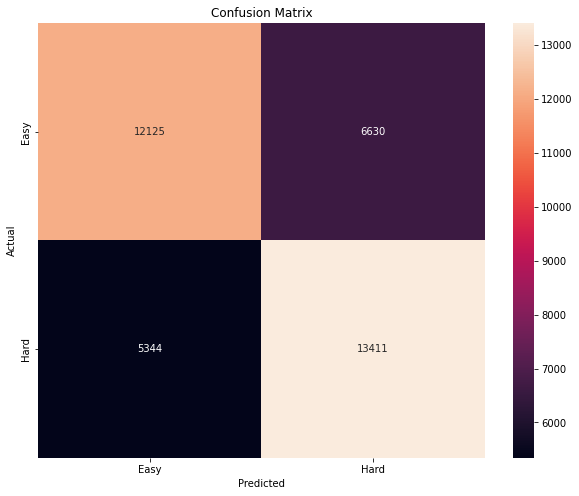

In [177]:
import seaborn as sns
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Easy','Hard'],
            yticklabels=['Easy','Hard'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.show();



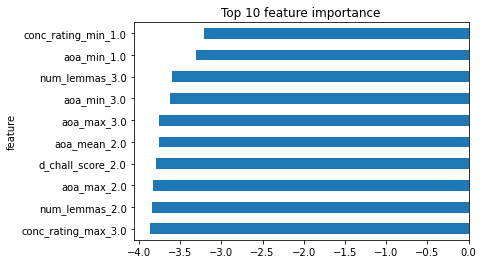

In [148]:

num_features_trf = (clf['preprocessor']
                    .transformers_[0][1]
                    ['binner']
                    .get_feature_names_out(num_features))

text_features_trf = (clf['preprocessor']
                 .transformers_[1][1]
                 ['tfidf']
                 .get_feature_names_out())

all_features_trf = list(num_features_trf) + list(text_features_trf)


df_coef = pd.DataFrame({'feature':all_features_trf, 
                        'coef':clf['clf'].coef_[0]})

df_coef= df_coef.sort_values('coef',ascending=False)[:10]


def generate_plot(df_plot):
  # since we're dealing with log_prob reverse the ordering so smallest on top
  df_plot= (df_plot.sort_values('coef',ascending=True)[:10]
   .plot.barh('feature', 'coef', 
                    legend=None,
              ))
  df_plot.set_title('Top 10 feature importance')
   
  
generate_plot(df_coef)


In [170]:
# Final Test on held out data set

X_test = test[X_features]
y_test = test.label

# cm = compute_metrics(clf,model_name,X_train, y_train, X_test, y_test)
print("Training Dataset")
print('Train Accuracy',round(metrics_df.iloc[0]['train_accuracy'],3))
print('Train Recall', round(metrics_df.iloc[0]['train_recall'],3))
print('Train Precision', round(metrics_df.iloc[0]['train_precision'],3))
print('Train F1', round(metrics_df.iloc[0]['train_f1'],3))
print('Train AUC PRC', round(metrics_df.iloc[0]['train_aucprc'],3))
print('Train AUC ROC', round(metrics_df.iloc[0]['train_aucroc'],3))
print(" ")
print("Testing Dataset")
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
y_proba = clf.predict_proba(X_test)[:,1]
prc,rec,thres = precision_recall_curve(y_test, y_proba)
auc_prc = auc(rec,prc)
roc = roc_auc_score(y_test, y_proba)

print('Test Accuracy:', round(acc,3))
print('Test Recall', round(recall,3))
print('Test Precision', round(precision,3))
print('Test F1-score', round(f1,3))
print('AUC PRC', round(auc_prc,3))
print('Test AUC ROC', round(roc,3))



Training Dataset
Train Accuracy 0.717
Train Recall 0.747
Train Precision 0.705
Train F1 0.725
Train AUC PRC 0.805
Train AUC ROC 0.798
 
Testing Dataset
Test Accuracy: 0.692
Test Recall 0.727
Test Precision 0.68
Test F1-score 0.703
AUC PRC 0.765
Test AUC ROC 0.765


In [172]:
from sklearn.metrics import confusion_matrix

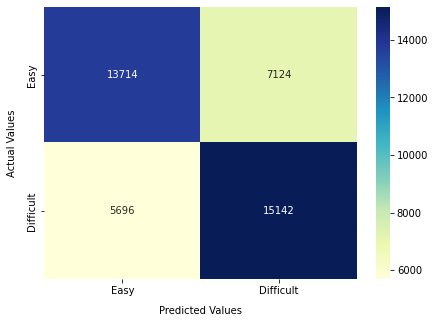

In [175]:
plot_cf_matrix(y_test,y_pred)

In [169]:
import joblib
model_path = ''.join(['drive/Shareddrives/Milestone 2/multinomialnaivebayes-clf.joblib'])
joblib.dump(clf['clf'], model_path)

['drive/Shareddrives/Milestone 2/multinomialnaivebayes-clf.joblib']

In [176]:
# Additional work was done for sentence embeddings as well as combined embeddings + Mads features below.

# Sentence Embeddings

In [ ]:
from numpy import loadtxt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
embeddings = loadtxt('drive/Shareddrives/Milestone 2/embeddings.csv', delimiter=',')
embeddings

In [ ]:
embeddings.shape

In [ ]:
# Combine the embeddings and the original_text + Mads features
emb = pd.DataFrame(embeddings)
new_df = pd.concat([df,emb], axis=1)
new_df.head()

In [ ]:
#Extract training
X_train_indexes = X_train.index
X_train_emb = new_df.iloc[X_train_indexes, 11:]



# Extract just the embedding data from test set
X_test_indexes = X_test.index
X_test_emb = new_df.iloc[X_test_indexes, 11:]

X_train_emb.head()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
embed_pipeline = Pipeline([('scaler', MinMaxScaler()),
                          ('clf',MultinomialNB())
                         ])

parameters = {
    'clf__alpha': [0.0001,0.001,0.01,0.1,1,5,10,50, 100,200,500]
}


grid_bnb_emb_f1 = (GridSearchCV(embed_pipeline,
                                 param_grid=parameters,
                                 scoring='f1',
                                 n_jobs=-1, 
                                 cv=10).fit(X_train_emb,y_train))


In [ ]:
grid_bnb_emb_f1.best_params_

In [ ]:
grid_bnb_emb_f1.best_estimator_.score(X_train_emb,y_train)

In [ ]:
model_name = 'embedding BNB alpha .0001'
# X_test_emb_mm = scaler.transform(X_test_emb)
compute_metrics(grid_bnb_emb_f1.best_estimator_,
                model_name,
                X_train_emb,
                y_train,
                X_test_emb,
                y_test)

# Sentence Embeddings + Mads Feaures

In [ ]:
model_name = "emb + mads"

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, Normalizer

In [ ]:
X_train_emb_mads = new_df.iloc[X_train.index].copy()
X_test_emb_mads = new_df.iloc[X_test.index].copy()

X_train_emb_mads.drop(['original_text','lemmatized_text','label'],inplace=True,axis=1)
X_test_emb_mads.drop(['original_text','lemmatized_text','label'],inplace=True,axis=1)


In [ ]:

mads_pipe = Pipeline([
              ('impute_mean',SimpleImputer(strategy='mean')),
              ])

preprocessor = ColumnTransformer(transformers=[
    ('mads',mads_pipe,cols)
    ])


              
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('scaler',MinMaxScaler()),
                     ('clf', MultinomialNB())  # classifier
                     ])


param_grid = {
    'clf__alpha': [0.001, 0.01, 0.1,1,2,3,4,5,10,50, 100,500]
}

In [ ]:
grid_bnb_embmads_f1 = GridSearchCV(pipeline,
                                    param_grid=param_grid,
                                    scoring='f1',
                                    n_jobs=-1,
                                    cv=10)
grid_bnb_embmads_f1.fit(X_train_emb_mads,y_train)

In [ ]:
grid_bnb_embmads_f1.best_params_

In [ ]:
grid_bnb_embmads_f1.best_estimator_.score(X_train_emb_mads,y_train)

In [ ]:
model_name += ' alpha 10'
compute_metrics(grid_bnb_embmads_f1.best_estimator_,model_name,X_train_emb_mads, y_train, X_test_emb_mads, y_test)

In [ ]:
metrics = pd.DataFrame(metrics_df)